# Practical 3: Projections and Transformations

This is the third practical session and now we're going to get into more of the geography-specific technical details. While this topic may seem less-glamorous than something on analysis, it's possibly the most important one if we want to make sure our analyses are accurate. There are lots of opportunities for pitfalls and errors to creep into our work when we deal with geographic coordinates. Here we will look at different geographic and projected coordinate reference systems. Then we will see how those are implemented with GeoPandas so that we can reproject GeoDataFrames.

Objectives:
* Know were to find coordinate reference system information
* Identify key projections for working with world and U.K.-based datasets
* Understand the potential distortions caused by certain projections
* View, define, and reproject geospatial vector data


In [1]:
# load packages
import pyproj # used internally by GeoPandas, but we'll use this for a few initial tests
import geopandas as gpd
import math

## Key definitions

Recall from the presentation:
1. **Projection** - a systematic transformation of coordinates. Typically a map projection relates latitudes and longitudes from the globe (3D) to a plane (2D) surface.
2. **Coordinate Reference System (CRS)** - defines how map coordinates relate to actual places on the earth.
3. **Ellipspoid** - a model of the approximate shape of the earth
4. **Datum** - a reference frame for an ellipsoid, locating the center of the earth

Note, these concepts aren't just for earth! There are a large set of coordinate systems for mapping things on mars and other planets, too.

## Coordinate reference systems

Let's begin by looking at the information stored in a CRS. There are many different possible options, and remember that [https://spatialreference.org/](https://spatialreference.org/) is a good reference for finding more examples.

We can load a CRS using `pyproj`.

In [2]:
# load a global, latitude/longitude CRS
crs1 = pyproj.CRS.from_epsg(4326)

crs1

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

There are few things to notice in the code above. First, we're using an *EPSG* code in the `.from_epsg` function. This is the European Petroleum Survey Group's code numbers to reference to geographic coordinate system, and over the years, they've become the standard for referring to spatial reference systems. You can find more about these here: [https://epsg.org/home.html](https://epsg.org/home.html)

Second, when we print the CRS, we see several lines with names and what look like parameters. Take a moment to look over these. The EPSG code we are using is *4326*. This is also named *WGS 84*. This is one of the most common CRS and you will encounter it frequently when working with latitude and longitude coordinates. Most GPS units by default map locations using WGS84.

Also note, WGS84 is the name for an Ellipsoid. The names that we see in this CRS are pointing to their own files with parameter values for things like the prime meridian used, the semi-major and semi-minor axes of a ellipse used to model the shape of the earth.

We see that the *ellipsoid* is listed. It also suggests a bounds. Certain CRS are only appropriate for small areas of interest. As you see, this one is for the entire globe as the bounding box extends from (-180, -90) to (180, 90).

If we want to see the details of the parameters, we can convert the CRS object into a well-known text format.

In [3]:
crs1.to_wkt()

'GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["unknown"],AREA["World"],BBOX[-90,-180,90,180]],ID["EPSG",4326]]'

The WKT information is what is stored in the `.prj` file associated with a shapefile.

Let's try inspecting a few more examples using common EPSG codes:

In [4]:
# a popular system for the UK
crs2 = pyproj.CRS.from_epsg(27700)

crs2

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

Unlike WGS84, we now have a *projected* coordinate system. It is not designed for mapping points on a globe, but for projected coordinates on a flat map. EPSG:27700 is the Ordnance Survey National Grid reference.

This CRS gives us some more detailed information that we didn't see before. There is a *datum* as well as an *ellipsoid* specified. And there is a much smaller suggested area of use.

Note especially the "Axis Info" section. When we are using *projected* coordinates we no longer have latitude and longitude *degrees*. These now become *eastings* and *northings*. Those measurements specify a distance away from an origin point. These measurements also have defined units: metres.

As we will see in a moment, projected CRS are what we should use for accurate measurements of things like area or distance. The units of the CRS determine the default units when calculating geometry-related measurements.

Another one:

In [5]:
# used by many web-mapping systems (e.g. Google maps)
crs3 = pyproj.CRS.from_epsg(3857)

crs3

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

EPSG 3857 is used by many of the tiled map services. Despite covering the whole world, notice that this is, in fact, a projected coordinate system. It has eastings and northings. Google maps, and other sites like that, aren't globes and they have a lot of distortions around the poles because of using this projection, as we will see.

In later practicals when we want to overlay our geographic data with some basemap imagery or if we want to work with web mapping, we'll need to remember to use this (or similar) projections.

In [6]:
# a popular global measurement system - place-secific
crs4 = pyproj.CRS.from_epsg(32618)

crs4

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 78°W to 72°W - by country
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The third example is part of the *Universal Transverse Mercator* or UTM projection. We saw an example of this in the lecture materials. UTM has a set of *zones* covering the globe in order to create a local *meridian* to improve the accuracy of local maps. Also notice the line about the Datum. UTM are built referencing the same WGS84 ellipsoid that we saw in the first example. 

There isn't a single "UTM" zone or projection for the entire globe. You need to know where (roughly) you are in order to get your UTM zone and the correct projection.

### Side track: Finding your UTM zone

One of my colleagues recently asked me, "I have a longitude/latitude location, how do I know which UTM zone to use?" 

Yes, you can look up on some of the maps of zones and eyeball which one to use and then look up the EPSG code on the websites. But UTM are actually incredibly regular, so you can identify the zone (and the EPSG) code with a simple calculation.

In [7]:
# function to return the UTM EPSG
def get_utm_zone(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code            

UTM zones are 6 degrees wide at the equator and there are 60 of them covering the globe. Some careful rounding and then differentiating northern vs. southern hemisphere codes. You can try substituting different coordinates in the function, too.

In [8]:
# test UTM function for the location of the UoS Geography Building
zn = get_utm_zone(-1.399073, 50.934358)
zn

'32630'

So this tells us that the UTM zone for Southampton is zone 30. The UK actually spans UTM zones 29 to 31.
[http://dmap.co.uk/utmworld.htm](http://dmap.co.uk/utmworld.htm).

In [9]:
# print UTM zone 30 CRS info
pyproj.CRS.from_epsg(zn)

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 6°W to 0°W - by country
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Which CRS or projection to use?

This is a common question for people starting out working with spatial data. There isn't one correct answer. Most of the time you will receive data and it will already have a CRS and/or projection defined. If you know you are working in a particular country (or state in the U.S.) you may want to re-project to a local system. It will depend on what sort of analyses you want to do.

In much of the rest of this practical we will try to demonstrate the tradeoffs and decisions you will need to make in order to which CRS and projection to use.

## Reprojecting geographic data

Let's imagine that we have some geographic data: a point with latitude and longitude coordinates. We're now going to see how these CRS files can be used to move between a geographic and a projected coordinate reference system.

We will start by doing a coordinate transformation manually. Then we'll move on to using the tools in `pyproj`. Then it will be time to return to `GeoPandas` and bring in a full `GeoDataFrame` of data.

### Manual reprojection example

Note: this is just a demonstration. Don't worry if the details of the functions aren't clear, and you won't need them to complete the practicals. To see more of this process explained, check out this reference: [http://fgg-web.fgg.uni-lj.si/~/mkuhar/Zalozba/TM_projection.pdf](http://fgg-web.fgg.uni-lj.si/~/mkuhar/Zalozba/TM_projection.pdf)

First we'll define a few functions.

In [10]:
# based on: https://scipython.com/book/chapter-2-the-core-python-language-i/additional-problems/converting-between-an-os-grid-reference-and-longitudelatitude/
# initial parameter steps
def fM(phi, a, b):
    """Return the parameter M for latitude phi using ellipsoid params a, b."""

    n = (a-b)/(a+b)
    n2 = n**2
    n3 = n * n2
    dphi, sphi = phi - phi0, phi + phi0
    M = b * F0 * (
            (1 + n + 5/4 * (n2+n3)) * dphi
          - (3*n + 3*n2 + 21/8 * n3) * math.sin(dphi) * math.cos(sphi)
          + (15/8 * (n2 + n3)) * math.sin(2*dphi) * math.cos(2*sphi)
          - (35/24 * n3 * math.sin(3*dphi) * math.cos(3*sphi))
        )
    return M

# key parameters
def get_prms(phi, a, F0, e2):
    """Calculate and return the parameters rho, nu, and eta2."""

    rho = a * F0 * (1-e2) * (1-e2*math.sin(phi)**2)**-1.5
    nu = a * F0 / math.sqrt(1-e2*math.sin(phi)**2)
    eta2 = nu/rho - 1
    return rho, nu, eta2

# main conversion function
def ll_to_os(phi, lam, datum='osgb36'):
    """Convert from latitude and longitude to OS grid reference (E, N).

    Latitude, phi, and longitude, lambda, are to be provided in degrees.

    """

    phi, lam = math.radians(phi), math.radians(lam)
    a, b = datum_ellipsoid[datum]['a'], datum_ellipsoid[datum]['b']
    e2 = (a**2 - b**2)/a**2
    rho, nu, eta2 = get_prms(phi, a, F0, e2)
    M = fM(phi, a, b)

    sin_phi = math.sin(phi)
    cos_phi = math.cos(phi)
    cos_phi2 = cos_phi**2
    cos_phi3 = cos_phi2 * cos_phi
    cos_phi5 = cos_phi3 * cos_phi2
    tan_phi2 = math.tan(phi)**2
    tan_phi4 = tan_phi2 * tan_phi2

    a1 = M + N0
    a2 = nu/2 * sin_phi * cos_phi
    a3 = nu/24 * sin_phi * cos_phi3 * (5 - tan_phi2 + 9*eta2)
    a4 = nu/720 * sin_phi * cos_phi5 * (61 - 58*tan_phi2 + tan_phi4)
    b1 = nu * cos_phi
    b2 = nu/6 * cos_phi3 * (nu/rho - tan_phi2)
    b3 = nu/120 * cos_phi5 * (5 - 18*tan_phi2 + tan_phi4 + eta2*(14 -
                              58*tan_phi2))
    lml0 = lam - lambda0
    lml02 = lml0**2
    N = a1 + lml02 * (a2 + lml02*(a3 + a4*lml02))
    E = E0 + lml0 * (b1 + lml02*(b2 + b3*lml02))
    return E, N

Next we need to define a few constants describing the different parameters of the Ellipsoids. This is the kind of information stored in those CRS files that are referenced by `pyproj`.

In [11]:
# Ellipsoid parameters for different datums (m): semi-major axis, a, and
# semi-minor axis, b.
datum_ellipsoid = {
    # Airy 1830 ellipsoid
    'osgb36': {'a': 6.377563396e6,
               'b': 6.356256909e6
              },
    # WGS84 ellipsoid parameters
    'wgs84':  {'a': 6.378137e6,
               'b': 6.3567523141e6
              },
    }

# Transverse Mercator projection parameters: Map coordinates of true origin,
# (E0, N0), scale factor on central meridian, F0, true origin (phi0, lambda0).
N0 = -100000
E0 = 400000
F0 = 0.9996012717
phi0 = math.radians(49)
lambda0 = math.radians(-2)

But these equations are **MISSING** something. To make them simpler they assume that the two CRS are using the same *datum*. Remember that Datums help to provide a reference for the ellipsoid model of the earth. By not including a datum transformation it means there will be slight inaccuracies when we move from something like WGS84 to the OS National Grid because they assume specific datum characteristics. Specifically, EPSG 27700 uses OSGB 1936 ellipsoid with Airy 1830 datum. 

Let's use the location of the UoS Geography building again to test our functions.

In [12]:
# convert lat, lon (phi, lambda) to OS Eastings, Northings
# note the order of the coordinates
ll_to_os(50.934358, -1.399073)

# remember, these units are now in metres

(442222.0696786785, 115222.99240281426)

### Reprojecting example with `pyproj`

The previous example of calculating the transformation is complicated and there are lots of opportunities for us to make mistakes. There are also lots of small details to remember like datums and ellipsoids and transformations.

Luckily, we rarely will ever need to do this kind of reprojection step manually and we have many tools to make this sort of thing easier. Let's now repeat this transformation using `pyproj`.

First, create a `pyproj.Transformer` that controls the reprojection between two defined CRS. Here we will EPSG codes that we've already seen before.

In [13]:
from pyproj import Transformer
# create a transformer object
# using the EPSG codes again
transformer = Transformer.from_crs(4326, 27700, always_xy=True)
# the `always_xy` argument enforces lon, lat order 

# alternatively, we could have use the saved CRS objects from above, (e.g. crs3) instead of EPSG codes

In [14]:
# it's simple to use the transformer with a coordinate pair!
# note the order of lon, lat which is different from our manual function
transformer.transform(-1.399073, 50.934358)

(442323.09780602425, 115162.8056389138)

Compare this result with the manual calculation we just did. 

Very close! As noted above, the difference is coming mainly because `pyproj` knows to apply the correct transformation when switching the datums.

## Coordinate reference systems in `GeoPandas`

The tools with `GeoPandas` makes working with coordinate reference systems relatively easy. When data are read into a `GeoDataFrame` the CRS information should automatically be added from the file.

In [15]:
# read in a sample dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [16]:
# retrieve the CRS information
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In this example, we can access the CRS through the `.crs` attribute of a GeoDataFrame. These data happen to be in EPSG:4326, or WGS 1984, which we saw in the section above.

What if we tried to modify that attribute?

In [17]:
# create a (deep) copy
world_cpy = world.copy()
# set the `.crs` to something else
world_cpy.crs = pyproj.CRS.from_epsg(3857)

world_cpy.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Python let's us do this, but **THIS IS INCORRECT**. The data have not been transformed, but GeoPandas now thinks the degrees of latitude and longitude are measurements taken in metres. We've shrunk the entire world!

The only time you might need to do this kind of assignment of a CRS is if the data you receive are missing the .prj file.

Now let's try doing this coordinate transformation the correct way by reprojecting these data.

In [18]:
# create a new GeoDataFrame to store the results so we can compare
# project to Web Mercator (EPSG:3857)
world_wm = world.to_crs(epsg=3857)  # can also use: .to_crs("EPSG:3857")

In [19]:
# compare the results
world_wm.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
# Let's compare some of the coordinates
print(world.geometry.head())

0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...
Name: geometry, dtype: geometry


In [21]:
# and after projections
print(world_wm.geometry.head())

0    MULTIPOLYGON (((20037508.343 -1812498.413, 200...
1    POLYGON ((3774143.866 -105758.362, 3792946.708...
2    POLYGON ((-964649.018 3205725.605, -964597.245...
3    MULTIPOLYGON (((-13674486.249 6274861.394, -13...
4    MULTIPOLYGON (((-13674486.249 6274861.394, -13...
Name: geometry, dtype: geometry


Notice the numbers are completely different now. The decimal degrees of latitude/longitude have been transformed into metres. This is the basic fact why the CRS is so important - if you want to overlay two datasets or to interact with them, you have to consider how they map their location on earth. Otherwise there will be problems in your analyses.

The difference in these maps is even more apparent when we visualise them side-by-side. This also gives us an opportunity to test out how to manipulate multiple plots, which we will do more of later.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

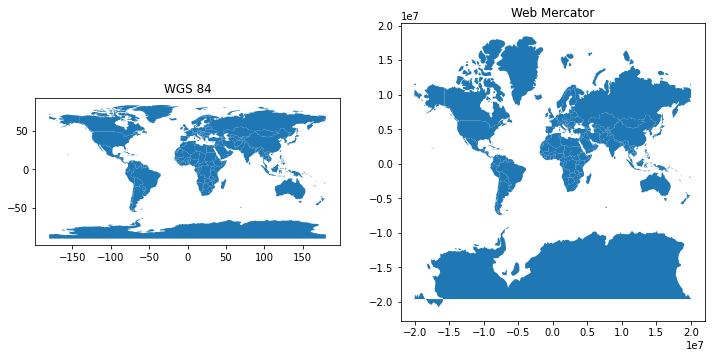

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# start sub-plots for side-by-side maps
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# plot the original data
world.plot(ax=ax1)
ax1.set_title("WGS 84")

# plot the reprojected data
world_wm.plot(ax=ax2)
ax2.set_title("Web Mercator")

# remove whitespace
plt.tight_layout

In the above figure, we start to see some of those distortions that are introduced by using projections.

### Testing different `CRS`

Based on the examples above, try reprojecting and then plotting the `world` dataset into a few of the other CRS using `.to_crs`. Store the reprojected datasets in new GeoDataFrames so we can compare them in the next section. You can use the EPSG codes that we tested above, or look for some others.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

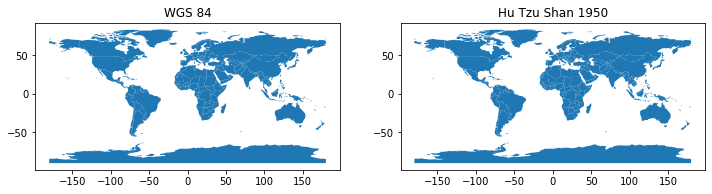

In [23]:
# Global lon/lat EPSG:4236 CRS Hu Tzu Shan 1950
world_hu = world.to_crs(epsg=4326)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# plot the original data
world.plot(ax=ax1)
ax1.set_title("WGS 84")

# plot the reprojected data
world_hu.plot(ax=ax2)
ax2.set_title("Hu Tzu Shan 1950")

# remove whitespace
plt.tight_layout


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

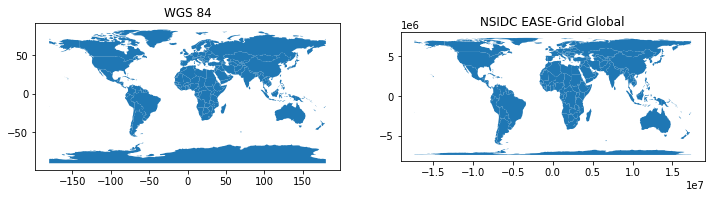

In [24]:
# EPSG:3410 NSIDC EASE-Grid Global
world_nsidc = world.to_crs(epsg=3410)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# plot the original data
world.plot(ax=ax1)
ax1.set_title("WGS 84")

# plot the reprojected data
world_nsidc.plot(ax=ax2)
ax2.set_title("NSIDC EASE-Grid Global")

# remove whitespace
plt.tight_layout

Experiment 2: what happens when you use a local UTM projection on a global dataset? (absolutely huge distortion, globally. Great locally)

<AxesSubplot:>

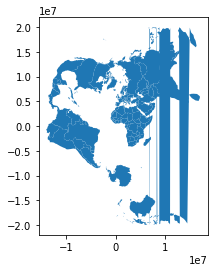

In [25]:
# use the UTM zone we calculated above for Southampton
world_utm = world.to_crs(32630)

world_utm.plot()

## Distortions in projections

We've already seen that the choice of projection can impact the appearance of the map. Certain projections distort parts of the globe, stretching them much larger than they are actually.

### Measuring areas

The distortions also show up when we're trying to calculate certain attributes of the spatial datasets. Here we will look at the area measurements, and in a later lesson we'll look at distance in more detail.

Remember that some projections are optimised to preserve certain properties, like area.

In [26]:
# check the initial area estimates for the UK
world.loc[world.name=='United Kingdom'].area

<ipython-input-26-e81a2070f41c>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world.loc[world.name=='United Kingdom'].area


143    34.202954
dtype: float64

In [27]:
# compare this with one of the projected coordinate systems
world_wm.loc[world_wm.name=='United Kingdom'].area  # units in sq. m

143    7.223808e+11
dtype: float64

These area results will now be in the units of the CRS. Of course, if we want a really accurate area measurement then we also need to consider the scale of our data. These country shapes have been generalised - the edges are simplified - so they aren't the best data to use to make a really accurate area measurement. 

In [28]:
# compare the area calculations with some of your projected datasets that you tested above.
world_hu.loc[world_hu.name=='United Kingdom'].area

<ipython-input-28-7d07ade5b321>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_hu.loc[world_hu.name=='United Kingdom'].area


143    34.202954
dtype: float64

In [29]:
world_nsidc.loc[world_nsidc.name=='United Kingdom'].area

143    2.488866e+11
dtype: float64

In [30]:
world_utm.loc[world_utm.name=='United Kingdom'].area

143    2.498843e+11
dtype: float64

### Global coordinate systems

Thus far we have been most concerned about plotting 2D maps and the distortions in them. Is it possible to plot data so that it looks more 3D? 

For that we need something called an "orthographic" projection. An orthographic projection is one that adds perspective to a plot so that it appears more three-dimensional.

This example starts by defining a custom CRS using a `proj` string. WKT formats or EPSG codes are a more consistent and accurate way to get the correct CRS and are recommended for typical uses. This alternative allows us to specify some very specific parameters.

For more information see the library site: [https://proj.org/](https://proj.org/).

In [31]:
# create a custom proj string
# based on https://automating-gis-processes.github.io/site/notebooks/LS/projections.html
ortho = pyproj.CRS.from_proj4("+proj=ortho +lat_0=50.00 +lon_0=-1.13 +x_0=0 +y_0=0 +a=6370997 +b=6370997 +units=m +no_defs")
# I have set the central point to be approximately over Southampton (50, -1.1)

Text(0.5, 1.0, 'Orthographic')

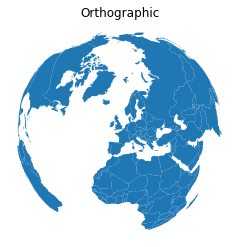

In [32]:
# reproject the world and plot
world_ortho = world.to_crs(ortho)

world_ortho.plot()

plt.axis('off')
plt.title("Orthographic")

### Alternative projections using `cartopy`

We can have access to even more projections (and some unique projections) by using another package called `cartopy`. Inside, this package uses a slightly different set-up from `pyproj`, so we will have to do some conversion steps but it still works with GeoPandas.

See more here: [https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html](https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html)

In [33]:
# load package
from cartopy import crs as ccrs

In [34]:
# create a CRS from `cartopy`
crs_new = ccrs.InterruptedGoodeHomolosine()

# loop through each geometry and calculate the projection
# from Mercator projection to Goode-Homolosine
new_geometries = [crs_new.project_geometry(ii, src_crs=ccrs.Mercator())
                  for ii in world_wm['geometry'].values]

In [35]:
# examine the CRS proj string - note the '+proj' parameter
crs_new.proj4_init

'+ellps=WGS84 +proj=igh +lon_0=0 +no_defs'

In [36]:
# we now have a list of new `shapely` geometries
print(new_geometries[0])

MULTIPOLYGON (((19846205.17731375 -1856296.084664847, 19777301.38333235 -1882205.084688199, 19704570.01416227 -1905789.769889185, 19699118.64604367 -1864047.274682329, 19756882.15081573 -1841079.610375882, 19791901.99966708 -1834930.265032727, 19855872.45588287 -1802769.504821679, 19851038.83239247 -1829532.797595796, 19846205.17731375 -1856296.084664847)), ((19629836.07353503 -1960948.419104451, 19659875.7871696 -1942491.652564127, 19689858.95817207 -1974788.7649332, 19660174.63331202 -2033229.038006566, 19591426.04514807 -2048607.058371267, 19536046.27815948 -2034765.734137061, 19535780.82352004 -1985555.307065798, 19584337.5055315 -1947105.602817988, 19629836.07353503 -1960948.419104451)), ((-19946992.42763627 -1799424.82580275, -19927834.17013166 -1794832.299435754, -19935827.02606293 -1848669.548723675, -19942131.07673567 -1853258.405276613, -19944561.76277961 -1826341.616496325, -19946992.42763627 -1799424.82580275)))


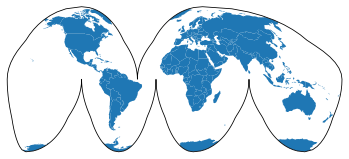

In [37]:
# cartopy allows us to plot the results
fig, ax = plt.subplots(subplot_kw={'projection': crs_new})
ax.add_geometries(new_geometries, crs=crs_new)

In [38]:
# these geometry data can be used to create a new GeoDataFrame
# start with the web mercator projection data, not the WGS84 coord system dataset
world_hs = gpd.GeoDataFrame(world_wm.drop('geometry', axis=1),  # just use the attributes
                            geometry = new_geometries,  # add in the new projected geometries
                            crs = crs_new.proj4_init    # convert cartopy's CRS to something GPD understands
                           )

world_hs.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((19846205.177 -1856296.085, 197..."
1,53950935,Africa,Tanzania,TZA,150600.0,"MULTIPOLYGON (((3773928.243 -106466.110, 37926..."
2,603253,Africa,W. Sahara,ESH,906.5,"MULTIPOLYGON (((-467335.869 3096342.145, -4696..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-12887523.448 5451633.640, -12..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-12887523.448 5451633.640, -12..."


<AxesSubplot:>

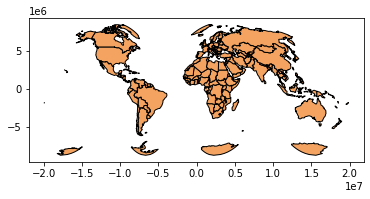

In [39]:
# plot the results with matplotlib and GeoPandas
world_hs.plot(facecolor='sandybrown', edgecolor='black')
# not quite as pretty as with cartopy

### Optional (if you have time): Try another `cartopy` projection

Follow the model from above, but try a different projection from the available ones here: [https://scitools.org.uk/cartopy/docs/latest/crs/projections.html](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)

In [40]:
# Testing space
crs_next = ccrs.Robinson()

# loop through each geometry and calculate the projection
# from Mercator projection to Robinson
next_geometries = [crs_next.project_geometry(ii, src_crs=ccrs.Mercator())
                  for ii in world_wm['geometry'].values]

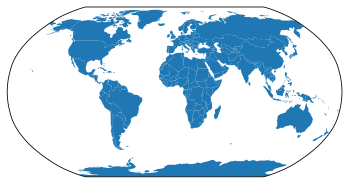

In [41]:
# cartopy allows us to plot the results
fig, ax = plt.subplots(subplot_kw={'projection': crs_next})
ax.add_geometries(next_geometries, crs=crs_next)

In [42]:
world_rob = gpd.GeoDataFrame(world_wm.drop('geometry', axis=1),  # just use the attributes
                            geometry = next_geometries,  # add in the new projected geometries
                            crs = crs_next.proj4_init    # convert cartopy's CRS to something GPD understands
                           )

world_rob.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((16794388.023 -1782144.586, 167..."
1,53950935,Africa,Tanzania,TZA,150600.0,"MULTIPOLYGON (((3202914.976 -102288.959, 32188..."
2,603253,Africa,W. Sahara,ESH,906.5,"MULTIPOLYGON (((-791055.189 2974837.054, -7911..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-10128870.949 5243003.413, -10..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-10128870.949 5243003.413, -98..."


<AxesSubplot:>

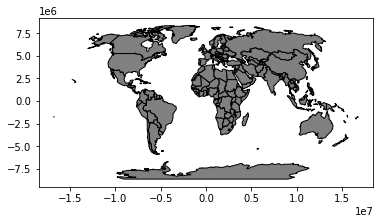

In [43]:
# plot the results with matplotlib and GeoPandas
world_rob.plot(facecolor='grey', edgecolor='black')

Finished!